# Figure 1
- Most adhesome genes are active
- Active adhesome genes are close in Hi-C maps

# Setup

In [97]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures0/correlation_clustering.py'>

In [98]:
# Specify all directories

# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [99]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Load adhesome only data

In [100]:
# Adhesome genes
active_adhesome_genes = pickle.load(open(saving_dir+'active_adhesome_genes.pkl', 'rb'))
adhesome_chr_loci = pickle.load(open(saving_dir+'adhesome_chr_loci.pkl', 'rb'))

In [101]:
# Load components
adhesome_components_filename = dir_adhesome+'components.csv'
df_components = lu.load_adhesome_data(adhesome_components_filename)

In [102]:
 # Load edge lists
adhesome_interX_edge_list = pickle.load(open(saving_dir+'adhesome_interX_edge_list.pkl', 'rb'))
adhesome_intraX_edge_list = pickle.load(open(saving_dir+'adhesome_intraX_edge_list.pkl', 'rb'))
# Load pairwise Spearman correlations between adhesome genes
adhesome_loc_corr = pickle.load(open(saving_dir+'adhesome_loc_corr.pkl','rb'))
# Add Spearman correlation to interX edge list
adhesome_interX_edge_list['spearman_corr'] = [adhesome_loc_corr.loc[adhesome_interX_edge_list.iloc[i]['source'],
                                                                    adhesome_interX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_interX_edge_list))]
# Add Spearman correlation to intraX edge list
adhesome_intraX_edge_list['spearman_corr'] = [adhesome_loc_corr.loc[adhesome_intraX_edge_list.iloc[i]['source'],
                                                                    adhesome_intraX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_intraX_edge_list))]

# Load adhesome+adhesome TFs data

In [103]:
# Load edge lists
selected_interX_edge_list = pickle.load(open(saving_dir+'selected_interX_edge_list.pkl', 'rb'))
selected_intraX_edge_list = pickle.load(open(saving_dir+'selected_intraX_edge_list.pkl', 'rb'))
# Load pairwise Spearman correlations between selected genes
adh_tf_loc_corr = pickle.load(open(saving_dir+'adh_tf_loc_corr.pkl','rb'))
# Add Spearman correlation to interX edge list
selected_interX_edge_list['spearman_corr'] = [adh_tf_loc_corr.loc[selected_interX_edge_list.iloc[i]['source'],
                                                                  selected_interX_edge_list.iloc[i]['target']]
                                              for i in range(len(selected_interX_edge_list))]
# Add Spearman correlation to intraX edge list
selected_intraX_edge_list['spearman_corr'] = [adh_tf_loc_corr.loc[selected_intraX_edge_list.iloc[i]['source'],
                                                                  selected_intraX_edge_list.iloc[i]['target']]
                                              for i in range(len(selected_intraX_edge_list))]

In [104]:
# Load adhesome loci and loci of TF targeting adhesome genes
tf_targeting_active_adhesome = pickle.load(open(saving_dir+'tf_targeting_active_adhesome.pkl', 'rb'))
adh_tf_chr_loci = pickle.load(open(saving_dir+'adh_tf_chr_loci.pkl', 'rb'))
adh_tf_genes = np.unique(adh_tf_chr_loci[adh_tf_chr_loci['active']==True]['gene'])
pickle.dump(adh_tf_genes, open(saving_dir+'adh_tf_genes.pkl', 'wb'))
adh_tf_loci = np.unique(adh_tf_chr_loci[adh_tf_chr_loci['active']==True]['locus_id'])
adh_tf_locus_gene_dict = pickle.load(open(saving_dir+'adh_tf_locus_gene_dict.pkl', 'rb'))
adh_tf_gene_locus_dict = pickle.load(open(saving_dir+'adh_tf_gene_locus_dict.pkl', 'rb'))
contacts_df2_tf = pickle.load(open(saving_dir+'contacts_df2_tf.pkl', 'rb'))

In [210]:
# Load TRRUST database
trrust_df = pickle.load(open(dir_genome+'trrust_df.pkl','rb'))

# Build networks and run clustering

### Build interX network

In [174]:
# Define parameters
hic_threshold = 0.72
with_intra = False
weights = 'spearman_corr'

In [175]:
# Build interX network
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','spearman_corr']]
adhesome_edge_list = inter_selected
if with_intra == True:
    adhesome_edge_list = pd.concat([adhesome_edge_list,intra_selected])
G_inter = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic','spearman_corr'])
G_inter.add_nodes_from(active_adhesome_genes)

In [177]:
# Run WCC
wcc = cc.weighted_correlation_clustering_micha(adhesome_interX_edge_list, 
                                               adhesome_intraX_edge_list,
                                               active_adhesome_genes,
                                               hic_threshold,
                                               with_intra,
                                               weights,
                                               num_calls=100,
                                               seed=13)
clustering_inter_wcc, vote_objective, boem_objective, num_clusters = wcc
print('Objective value after vote = ', vote_objective)
print('Objective value after boem = ', boem_objective)
print('Number of clusters = ', num_clusters)

# Clustered graph
G_inter_wcc = G_inter.copy()
labels = np.array(sorted(G_inter_wcc.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(G_inter_wcc, {labels[i]: str(clustering_inter_wcc[i]) for i in range(n)}, "wcc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(G_inter_wcc, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(G_inter_wcc, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_inter_wcc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_inter_wcc])]
G_inter_wcc.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(G_inter_wcc, filename=saving_dir+"G_inter_wcc.html")

Objective value after vote =  198.492
Objective value after boem =  192.495
Number of clusters =  156


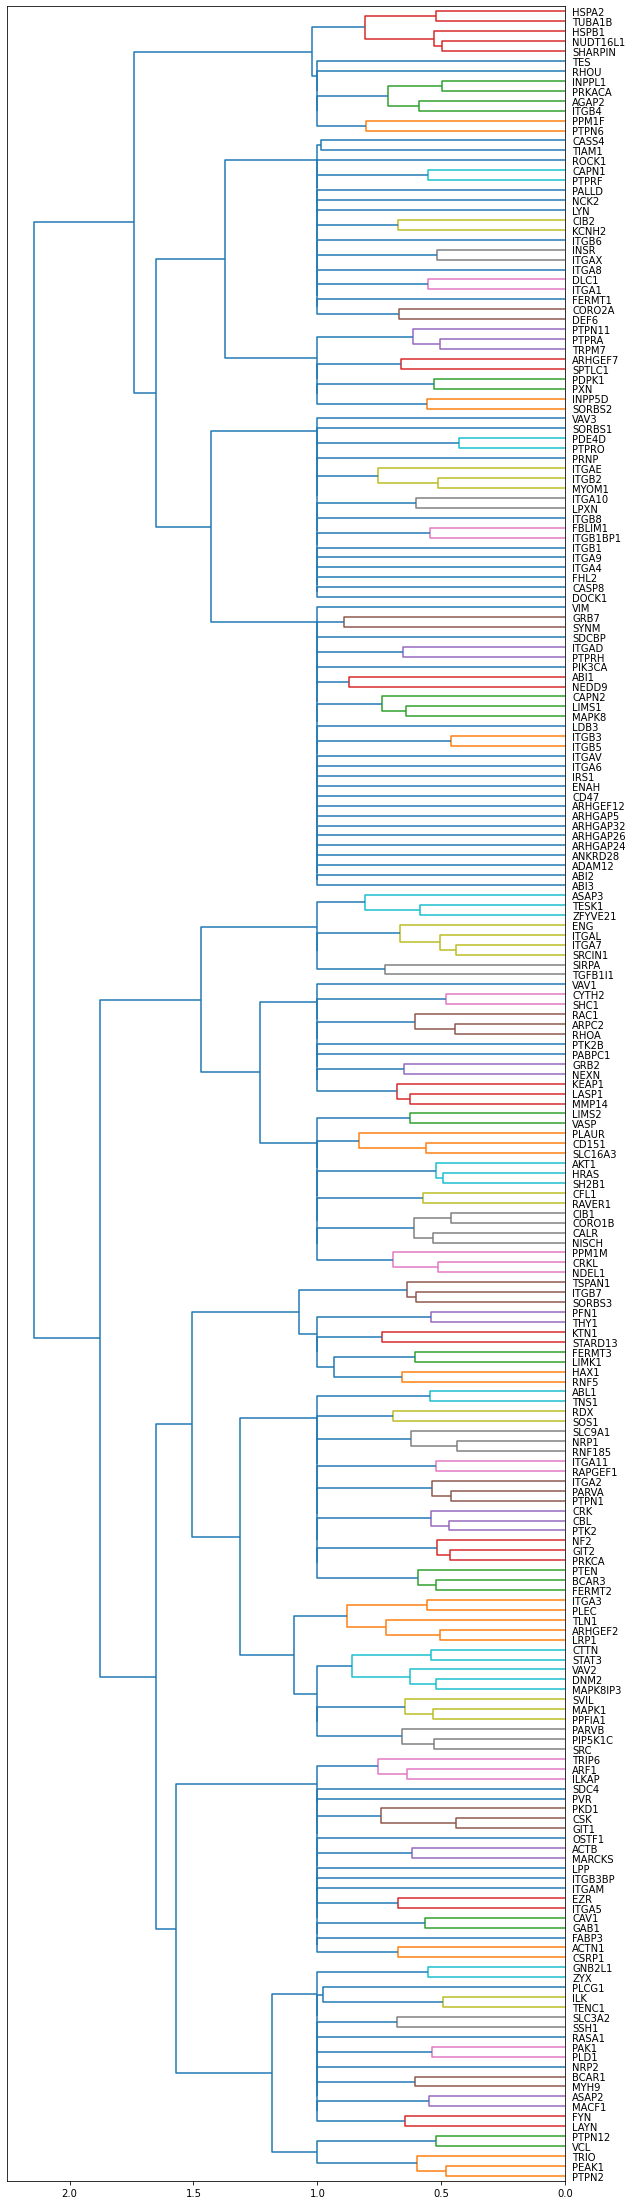

Number of clusters = 118
Number of singletons = 52
Number of nodes in non trivial clusters = 167


In [178]:
# Run HCC
hc_threshold = 0.9
clustering_inter_hc = cc.hierarchical_clustering(adhesome_interX_edge_list, 
                                                  adhesome_intraX_edge_list,
                                                  active_adhesome_genes,
                                                  hic_threshold,
                                                  with_intra,
                                                  weights,
                                                  hc_threshold,
                                                  plot=True)
# Clustering characteristics
comps = np.unique(np.unique(clustering_inter_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_inter_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_inter_hc)-comps[1][0]))

# Clustered graph
G_inter_hc = G_inter.copy()
labels = np.array(sorted(G_inter_hc.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(G_inter_hc, {labels[i]: str(clustering_inter_hc[i]) for i in range(n)}, "hc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(G_inter_hc, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(G_inter_hc, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_inter_hc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_inter_hc])]
G_inter_hc.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(G_inter_hc, filename=saving_dir+"G_inter_hc.html")

### Build intraX network

In [179]:
# Define parameters
hic_threshold = 0.72
with_intra = True
weights = 'spearman_corr'

In [180]:
# Selected edge list
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','spearman_corr']]
adhesome_edge_list = inter_selected
if with_intra == True:
    adhesome_edge_list = pd.concat([adhesome_edge_list,intra_selected])
G_intra = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic','spearman_corr'])
G_intra.add_nodes_from(active_adhesome_genes)

In [182]:
# Run WCC
wcc = cc.weighted_correlation_clustering_micha(adhesome_interX_edge_list, 
                                               adhesome_intraX_edge_list,
                                               active_adhesome_genes,
                                               hic_threshold,
                                               with_intra,
                                               weights,
                                               num_calls=100,
                                               seed=13)
clustering_intra_wcc, vote_objective, boem_objective, num_clusters = wcc
print('Objective value after vote = ', vote_objective)
print('Objective value after boem = ', boem_objective)
print('Number of clusters = ', num_clusters)

# Clustered graph
G_intra_wcc = G_intra.copy()
labels = np.array(sorted(G_intra_wcc.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(G_intra_wcc, {labels[i]: str(clustering_intra_wcc[i]) for i in range(n)}, "wcc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(G_intra_wcc, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(G_intra_wcc, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_intra_wcc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_intra_wcc])]
G_intra_wcc.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(G_intra_wcc, filename=saving_dir+"G_intra_wcc.html")

Objective value after vote =  213.28
Objective value after boem =  209.432
Number of clusters =  146


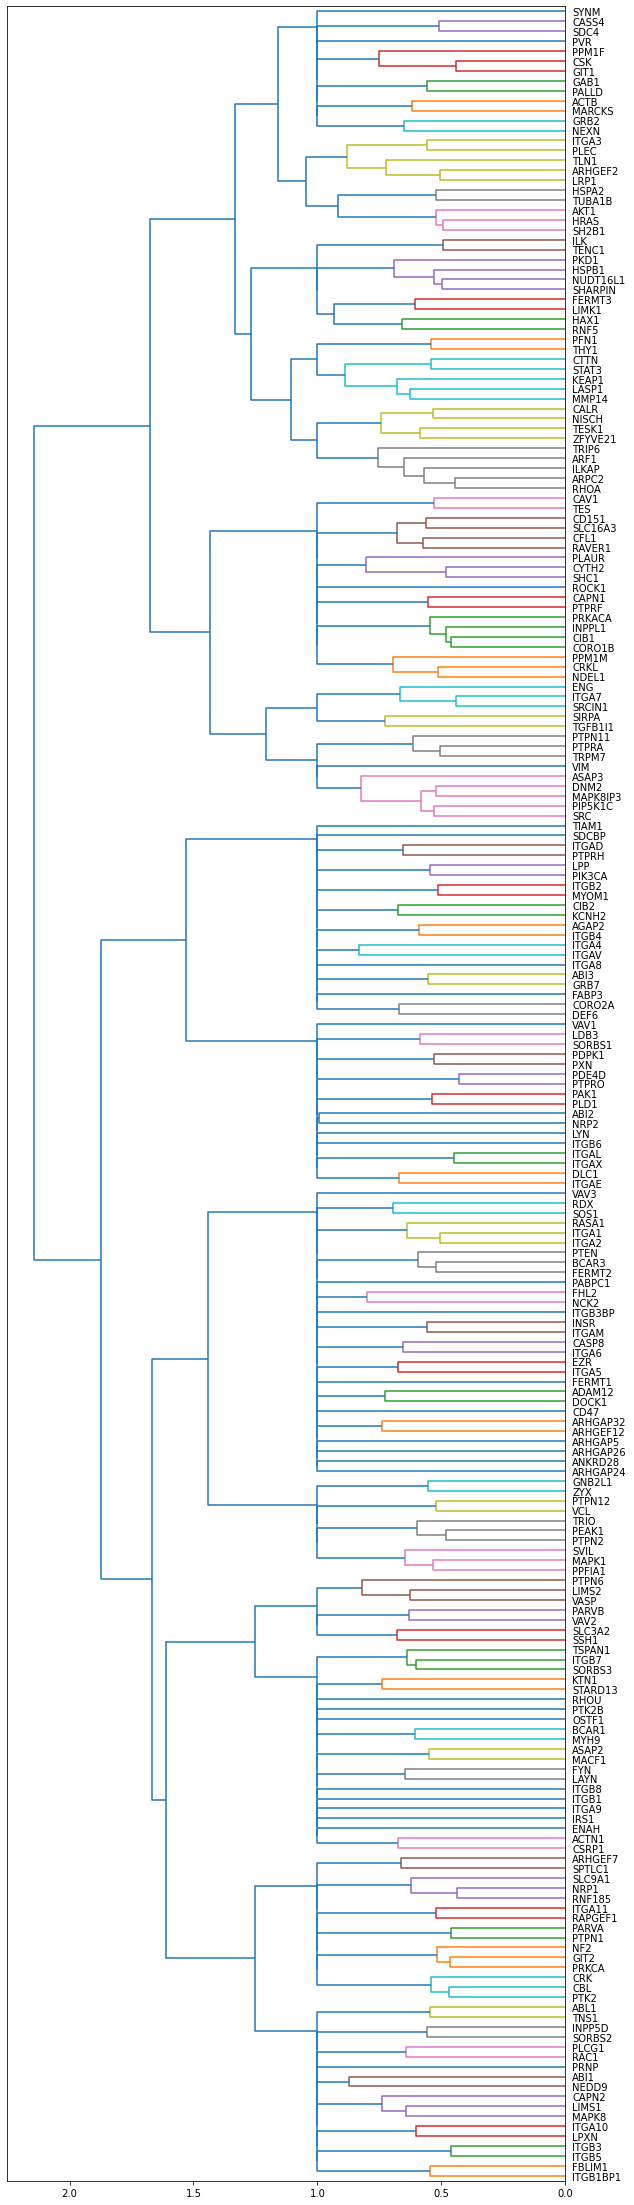

Number of clusters = 107
Number of singletons = 31
Number of nodes in non trivial clusters = 188


In [183]:
# Run HCC
hc_threshold = 0.9
clustering_intra_hc = cc.hierarchical_clustering(adhesome_interX_edge_list, 
                                                  adhesome_intraX_edge_list,
                                                  active_adhesome_genes,
                                                  hic_threshold,
                                                  with_intra,
                                                  weights,
                                                  hc_threshold,
                                                  plot=True)
# Clustering characteristics
comps = np.unique(np.unique(clustering_intra_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_intra_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_intra_hc)-comps[1][0]))

# Clustered graph
G_intra_hc = G_intra.copy()
labels = np.array(sorted(G_intra_hc.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(G_intra_hc, {labels[i]: str(clustering_intra_hc[i]) for i in range(n)}, "hc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(G_intra_hc, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(G_intra_hc, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_intra_hc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_intra_hc])]
G_intra_hc.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(G_intra_hc, filename=saving_dir+"G_intra_hc.html")

### Build interX network with adhesome TFs

In [186]:
# Define parameters
hic_threshold = 0.75
with_intra = False
weights = 'spearman_corr'

In [187]:
# Selected edge list
t = np.quantile(selected_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(selected_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = selected_interX_edge_list[selected_interX_edge_list['scaled_hic']>t]
intra_selected = selected_intraX_edge_list[selected_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','spearman_corr']]
selected_edge_list = inter_selected
if with_intra == True:
    selected_edge_list = pd.concat([selected_edge_list,intra_selected])
G = nx.from_pandas_edgelist(selected_edge_list, edge_attr=['hic','scaled_hic','spearman_corr'])
G.add_nodes_from(adh_tf_genes)

In [188]:
# Run WCC
wcc = cc.weighted_correlation_clustering_micha(selected_interX_edge_list, 
                                               selected_intraX_edge_list,
                                               adh_tf_genes,
                                               hic_threshold,
                                               with_intra,
                                               weights,
                                               num_calls=100,
                                               seed=13)
clustering_inter_tf_wcc, vote_objective, boem_objective, num_clusters = wcc
print('Objective value after vote = ', vote_objective)
print('Objective value after boem = ', boem_objective)
print('Number of clusters = ', num_clusters)
comps = np.unique(np.unique(clustering_inter_tf_wcc, return_counts=True)[1],return_counts=True)
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_inter_tf_wcc)-comps[1][0]))

# Clustered graph
cG = G.copy()
labels = np.array(sorted(cG.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(cG, {labels[i]: str(clustering_inter_tf_wcc[i]) for i in range(n)}, "wcc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(cG, {labels[i]: adh_tf_chr_loci[adh_tf_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(cG, {labels[i]: str(labels[i] in active_adhesome_genes) for i in range(n)}, "adhesome_gene")
nx.set_node_attributes(cG, {labels[i]: str(labels[i] in tf_targeting_active_adhesome) for i in range(n)}, "adhesome_tf_gene")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_inter_tf_wcc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_inter_tf_wcc])]
cG.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_wcc_intra_withtfs.html")
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_wcc_nointra_withtfs.html")

Objective value after vote =  403.823
Objective value after boem =  395.687
Number of clusters =  232
Number of singletons = 164
Number of nodes in non trivial clusters = 175


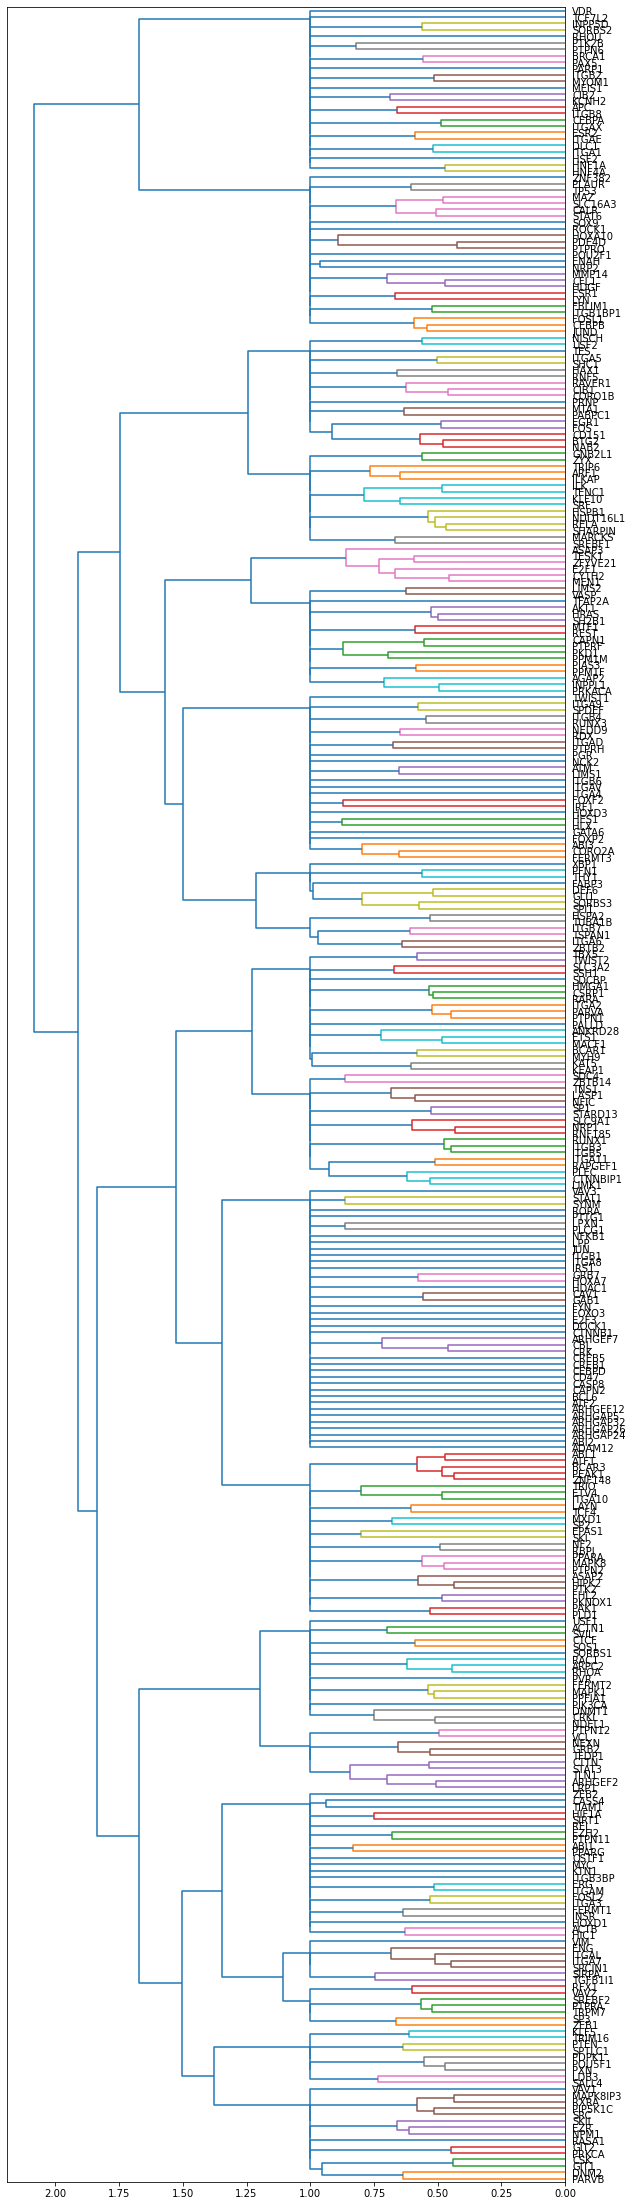

Number of clusters = 181
Number of singletons = 74
Number of nodes in non trivial clusters = 265


In [189]:
# Run HC
hc_threshold = 0.9
clustering_inter_tf_hc = cc.hierarchical_clustering(selected_interX_edge_list, 
                                                  selected_intraX_edge_list,
                                                  adh_tf_genes,
                                                  hic_threshold,
                                                  with_intra,
                                                  weights,
                                                  hc_threshold,
                                                  plot=True)
# Clustering characteristics
comps = np.unique(np.unique(clustering_inter_tf_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_inter_tf_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_inter_tf_hc)-comps[1][0]))


# Clustered graph
cG = G.copy()
labels = np.array(sorted(cG.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(cG, {labels[i]: str(clustering_inter_tf_hc[i]) for i in range(n)}, "hc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(cG, {labels[i]: adh_tf_chr_loci[adh_tf_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(cG, {labels[i]: str(labels[i] in active_adhesome_genes) for i in range(n)}, "adhesome_gene")
nx.set_node_attributes(cG, {labels[i]: str(labels[i] in tf_targeting_active_adhesome) for i in range(n)}, "adhesome_tf_gene")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_inter_tf_hc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_inter_tf_hc])]
cG.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_hc_intra_withtfs.html")
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_hc_nointra_withtfs.html")

### Build interX+intraX network with adhesome TFs

In [190]:
# Define parameters
hic_threshold = 0.75
with_intra = True
weights = 'spearman_corr'

In [191]:
# Selected edge list
t = np.quantile(selected_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(selected_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = selected_interX_edge_list[selected_interX_edge_list['scaled_hic']>t]
intra_selected = selected_intraX_edge_list[selected_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','spearman_corr']]
selected_edge_list = inter_selected
if with_intra == True:
    selected_edge_list = pd.concat([selected_edge_list,intra_selected])
G = nx.from_pandas_edgelist(selected_edge_list, edge_attr=['hic','scaled_hic','spearman_corr'])
G.add_nodes_from(adh_tf_genes)

In [192]:
# Run WCC
wcc = cc.weighted_correlation_clustering_micha(selected_interX_edge_list, 
                                               selected_intraX_edge_list,
                                               adh_tf_genes,
                                               hic_threshold,
                                               with_intra,
                                               weights,
                                               num_calls=100,
                                               seed=13)
clustering_intra_tf_wcc, vote_objective, boem_objective, num_clusters = wcc
print('Objective value after vote = ', vote_objective)
print('Objective value after boem = ', boem_objective)
print('Number of clusters = ', num_clusters)
comps = np.unique(np.unique(clustering_intra_tf_wcc, return_counts=True)[1],return_counts=True)
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_intra_tf_wcc)-comps[1][0]))

# Clustered graph
cG = G.copy()
labels = np.array(sorted(cG.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(cG, {labels[i]: str(clustering_intra_tf_wcc[i]) for i in range(n)}, "wcc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(cG, {labels[i]: adh_tf_chr_loci[adh_tf_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(cG, {labels[i]: str(labels[i] in active_adhesome_genes) for i in range(n)}, "adhesome_gene")
nx.set_node_attributes(cG, {labels[i]: str(labels[i] in tf_targeting_active_adhesome) for i in range(n)}, "adhesome_tf_gene")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_intra_tf_wcc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_intra_tf_wcc])]
cG.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_wcc_intra_withtfs.html")
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_wcc_nointra_withtfs.html")

Objective value after vote =  471.821
Objective value after boem =  460.289
Number of clusters =  221
Number of singletons = 144
Number of nodes in non trivial clusters = 195


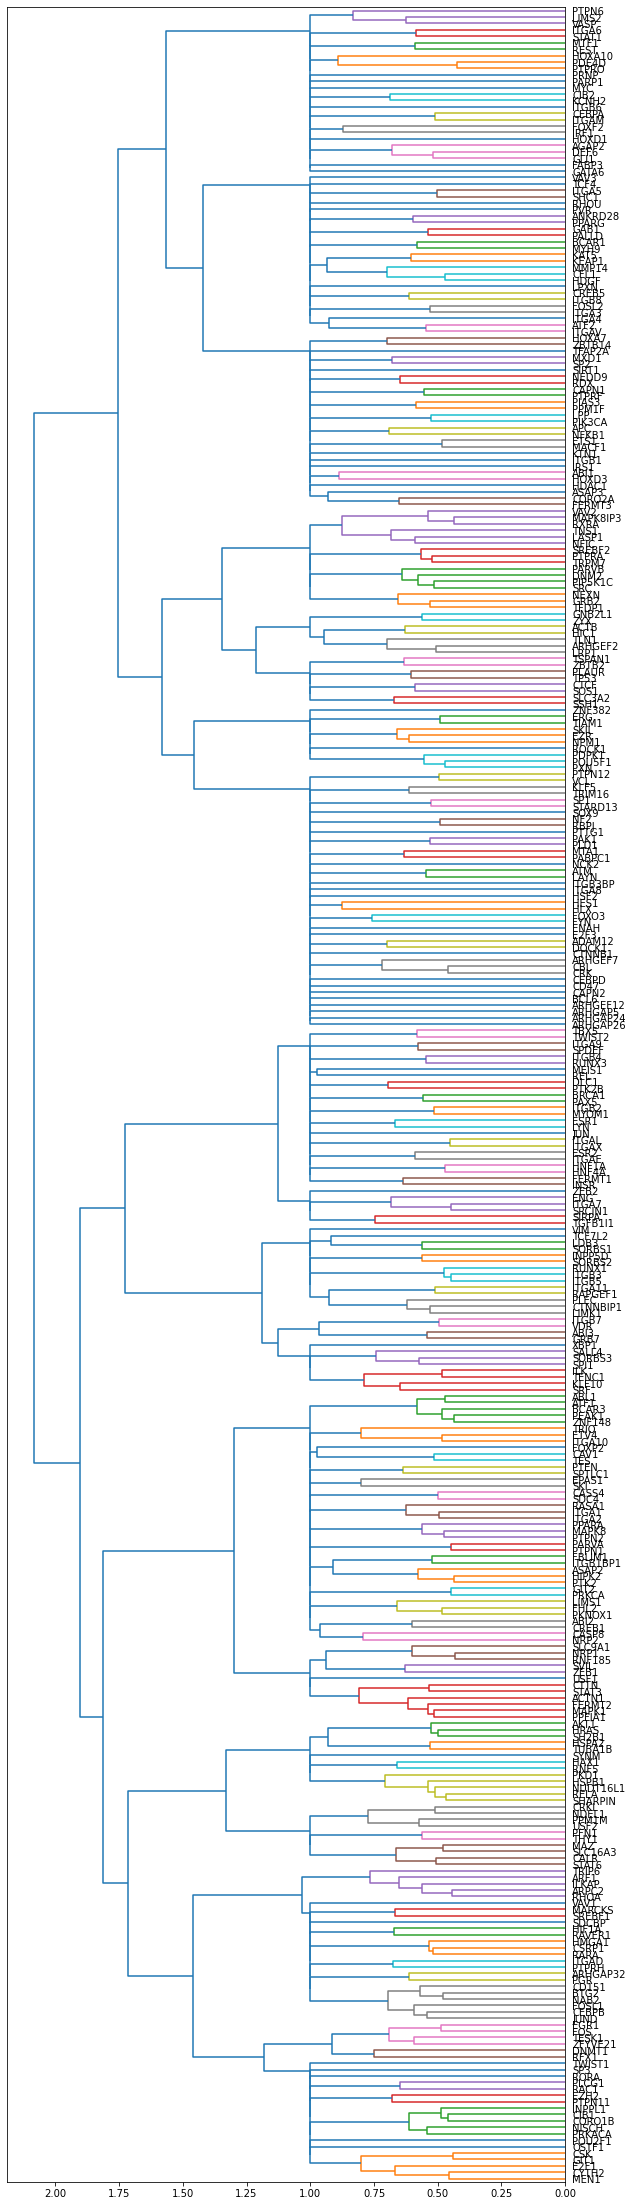

Number of clusters = 168
Number of singletons = 56
Number of nodes in non trivial clusters = 283


In [193]:
# Run HC
hc_threshold = 0.9
clustering_intra_tf_hc = cc.hierarchical_clustering(selected_interX_edge_list, 
                                                  selected_intraX_edge_list,
                                                  adh_tf_genes,
                                                  hic_threshold,
                                                  with_intra,
                                                  weights,
                                                  hc_threshold,
                                                  plot=True)
# Clustering characteristics
comps = np.unique(np.unique(clustering_intra_tf_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_intra_tf_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_intra_tf_hc)-comps[1][0]))


# Clustered graph
cG = G.copy()
labels = np.array(sorted(cG.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(cG, {labels[i]: str(clustering_intra_tf_hc[i]) for i in range(n)}, "hc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(cG, {labels[i]: adh_tf_chr_loci[adh_tf_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(cG, {labels[i]: str(labels[i] in active_adhesome_genes) for i in range(n)}, "adhesome_gene")
nx.set_node_attributes(cG, {labels[i]: str(labels[i] in tf_targeting_active_adhesome) for i in range(n)}, "adhesome_tf_gene")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_intra_tf_hc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_intra_tf_hc])]
cG.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_hc_intra_withtfs.html")
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_hc_nointra_withtfs.html")

# Compare interX and interX/intraX clustering of adhesome genes

### Cluster overlap matrix: WCC inter vs. WCC inter+intra

In [194]:
# Compare clusterings
matching_clusters_wcc = cc.compare_clusterings(clustering_inter_wcc, 
                                               clustering_intra_wcc, 
                                               active_adhesome_genes, 
                                               matching_thresh=0.4)
matching_clusters_wcc

Number of clustering1 clusters = 156
Number of clustering2 clusters = 146
Number of matching clusters = 30
Number of exactly matching clusters = 23
Number of genes in matching clustering1 clusters = 78
Number of genes in matching clustering2 clusters = 82


,clustering1_cluster_id,clustering2_cluster_id,clustering1_cluster,clustering2_cluster,n_clustering1_clusters,n_clustering2_clusters,match
7,35,35,"[CRK, GIT2, NF2, PEAK1, PTPN2]","[CRK, GIT2, NF2, PEAK1, PTPN2]",5,5,1.000000
11,49,50,"[FERMT2, MAPK1, PPFIA1, PTK2]","[FERMT2, MAPK1, PPFIA1, PTK2]",4,4,1.000000
0,4,4,"[ABL1, CBL, PRKCA]","[ABL1, CBL, PRKCA]",3,3,1.000000
20,65,64,"[ITGA11, ITGB3, ITGB5]","[ITGA11, ITGB3, ITGB5]",3,3,1.000000
21,66,65,"[ITGA2, PARVA, PTPN1]","[ITGA2, PARVA, PTPN1]",3,3,1.000000
1,8,8,"[AGAP2, ITGB4]","[AGAP2, ITGB4]",2,2,1.000000
2,17,17,"[ARHGEF2, LRP1]","[ARHGEF2, LRP1]",2,2,1.000000
3,22,22,"[BCAR1, MYH9]","[BCAR1, MYH9]",2,2,1.000000
5,25,25,"[CAPN1, PTPRF]","[CAPN1, PTPRF]",2,2,1.000000
8,38,39,"[CTTN, STAT3]","[CTTN, STAT3]",2,2,1.000000


### Cluster overlap matrix: HC inter vs. HC inter+intra

In [195]:
# Compare clusterings
matching_clusters_hc = cc.compare_clusterings(clustering_inter_hc, 
                                              clustering_intra_hc, 
                                              active_adhesome_genes, 
                                              matching_thresh=0.4)
matching_clusters_hc

Number of clustering1 clusters = 118
Number of clustering2 clusters = 107
Number of matching clusters = 55
Number of exactly matching clusters = 44
Number of genes in matching clustering1 clusters = 136
Number of genes in matching clustering2 clusters = 138


,clustering1_cluster_id,clustering2_cluster_id,clustering1_cluster,clustering2_cluster,n_clustering1_clusters,n_clustering2_clusters,match
39,90,8,"[ARHGEF2, ITGA3, LRP1, PLEC, TLN1]","[ARHGEF2, ITGA3, LRP1, PLEC, TLN1]",5,5,1.000000
5,20,28,"[PTPN11, PTPRA, TRPM7]","[PTPN11, PTPRA, TRPM7]",3,3,1.000000
15,41,103,"[CAPN2, LIMS1, MAPK8]","[CAPN2, LIMS1, MAPK8]",3,3,1.000000
23,73,10,"[AKT1, HRAS, SH2B1]","[AKT1, HRAS, SH2B1]",3,3,1.000000
25,76,24,"[CRKL, NDEL1, PPM1M]","[CRKL, NDEL1, PPM1M]",3,3,1.000000
26,77,79,"[ITGB7, SORBS3, TSPAN1]","[ITGB7, SORBS3, TSPAN1]",3,3,1.000000
33,84,94,"[NRP1, RNF185, SLC9A1]","[NRP1, RNF185, SLC9A1]",3,3,1.000000
36,87,98,"[CBL, CRK, PTK2]","[CBL, CRK, PTK2]",3,3,1.000000
37,88,97,"[GIT2, NF2, PRKCA]","[GIT2, NF2, PRKCA]",3,3,1.000000
38,89,56,"[BCAR3, FERMT2, PTEN]","[BCAR3, FERMT2, PTEN]",3,3,1.000000


### Cluster overlap matrix: WCC inter vs. HC inter

In [196]:
# Compare clusterings
matching_clusters_whc_inter = cc.compare_clusterings(clustering_inter_wcc, 
                                                     clustering_inter_hc, 
                                                     active_adhesome_genes, 
                                                     matching_thresh=0.4)
matching_clusters_whc_inter

Number of clustering1 clusters = 156
Number of clustering2 clusters = 118
Number of matching clusters = 29
Number of exactly matching clusters = 17
Number of genes in matching clustering1 clusters = 68
Number of genes in matching clustering2 clusters = 73


,clustering1_cluster_id,clustering2_cluster_id,clustering1_cluster,clustering2_cluster,n_clustering1_clusters,n_clustering2_clusters,match
17,66,86,"[ITGA2, PARVA, PTPN1]","[ITGA2, PARVA, PTPN1]",3,3,1.000000
26,118,20,"[PTPN11, PTPRA, TRPM7]","[PTPN11, PTPRA, TRPM7]",3,3,1.000000
1,22,112,"[BCAR1, MYH9]","[BCAR1, MYH9]",2,2,1.000000
3,25,8,"[CAPN1, PTPRF]","[CAPN1, PTPRF]",2,2,1.000000
4,29,98,"[CAV1, GAB1]","[CAV1, GAB1]",2,2,1.000000
7,40,11,"[DLC1, ITGA1]","[DLC1, ITGA1]",2,2,1.000000
9,50,80,"[FERMT3, LIMK1]","[FERMT3, LIMK1]",2,2,1.000000
10,53,107,"[GNB2L1, ZYX]","[GNB2L1, ZYX]",2,2,1.000000
12,59,108,"[ILK, TENC1]","[ILK, TENC1]",2,2,1.000000
13,61,23,"[INPP5D, SORBS2]","[INPP5D, SORBS2]",2,2,1.000000


### Cluster overlap matrix: WCC inter+intra vs. HC inter+intra

In [197]:
# Compare clusterings
matching_clusters_whc_intra = cc.compare_clusterings(clustering_intra_wcc, 
                                                     clustering_intra_hc, 
                                                     active_adhesome_genes, 
                                                     matching_thresh=0.4)
matching_clusters_whc_intra

Number of clustering1 clusters = 146
Number of clustering2 clusters = 107
Number of matching clusters = 31
Number of exactly matching clusters = 20
Number of genes in matching clustering1 clusters = 79
Number of genes in matching clustering2 clusters = 77


,clustering1_cluster_id,clustering2_cluster_id,clustering1_cluster,clustering2_cluster,n_clustering1_clusters,n_clustering2_clusters,match
0,3,37,"[ABI3, GRB7]","[ABI3, GRB7]",2,2,1.000000
1,8,35,"[AGAP2, ITGB4]","[AGAP2, ITGB4]",2,2,1.000000
3,20,82,"[ASAP2, MACF1]","[ASAP2, MACF1]",2,2,1.000000
4,22,81,"[BCAR1, MYH9]","[BCAR1, MYH9]",2,2,1.000000
6,25,22,"[CAPN1, PTPRF]","[CAPN1, PTPRF]",2,2,1.000000
7,28,1,"[CASS4, SDC4]","[CASS4, SDC4]",2,2,1.000000
8,29,19,"[CAV1, TES]","[CAV1, TES]",2,2,1.000000
13,48,106,"[FBLIM1, ITGB1BP1]","[FBLIM1, ITGB1BP1]",2,2,1.000000
14,51,13,"[FERMT3, LIMK1]","[FERMT3, LIMK1]",2,2,1.000000
15,54,3,"[GAB1, PALLD]","[GAB1, PALLD]",2,2,1.000000


# Stability of interX clusters upon addition of TFs

### Cluster overlap matrix: WCC inter adhesome vs. WCC inter adhesome+TF

In [198]:
# Compare clusterings
matching_clusters_wcc_inter_withtf = cc.compare_clusterings_with_tfs(clustering_inter_wcc, 
                                                                     clustering_inter_tf_wcc, 
                                                                     active_adhesome_genes, 
                                                                     adh_tf_genes, 
                                                                     matching_thresh=0.4)
matching_clusters_wcc_inter_withtf

Number of clustering1 clusters = 156
Number of clustering2 clusters = 232
Number of matching clusters = 46
Number of exactly matching clusters = 21
Number of genes in matching clustering1 clusters = 113
Number of genes in matching clustering2 clusters = 126


,clustering1_cluster_id,clustering2_cluster_id,clustering1_cluster,clustering2_cluster,n_clustering1_clusters,n_clustering2_clusters,match
12,32,41,"[CIB1, INPPL1, NISCH, PRKACA, SH2B1]","[CIB1, INPPL1, NISCH, PRKACA, SH2B1]",5,5,1.000000
19,49,74,"[FERMT2, MAPK1, PPFIA1, PTK2]","[FERMT2, HIPK2, MAPK1, PPFIA1, PTK2]",4,5,1.000000
0,4,4,"[ABL1, CBL, PRKCA]","[ABL1, CBL, CRK, GIT2, PKNOX1, PRKCA, RNF185, ...",3,8,1.000000
28,65,103,"[ITGA11, ITGB3, ITGB5]","[ITGA11, ITGB3, ITGB5, RUNX1]",3,4,1.000000
34,94,133,"[MAPK8IP3, PIP5K1C, SRC]","[MAPK8IP3, PIP5K1C, RXRA, SRC]",3,4,1.000000
29,66,104,"[ITGA2, PARVA, PTPN1]","[ITGA2, PARVA, PTPN1]",3,3,1.000000
2,9,9,"[AKT1, CORO1B]","[AKT1, CORO1B, E2F1]",2,3,1.000000
38,107,158,"[PDPK1, PXN]","[PDPK1, POU5F1, PXN]",2,3,1.000000
43,124,150,"[RAPGEF1, SLC9A1]","[NRP1, RAPGEF1, SLC9A1]",2,3,1.000000
4,17,18,"[ARHGEF2, LRP1]","[ARHGEF2, LRP1]",2,2,1.000000


### Cluster overlap matrix: HC inter adhesome vs. HC inter adhesome+TF

In [199]:
# Compare clusterings
matching_clusters_hc_inter_withtf = cc.compare_clusterings_with_tfs(clustering_inter_hc, 
                                                                    clustering_inter_tf_hc, 
                                                                    active_adhesome_genes, 
                                                                    adh_tf_genes, 
                                                                    matching_thresh=0.4)
matching_clusters_hc_inter_withtf

Number of clustering1 clusters = 118
Number of clustering2 clusters = 181
Number of matching clusters = 76
Number of exactly matching clusters = 29
Number of genes in matching clustering1 clusters = 179
Number of genes in matching clustering2 clusters = 205


,clustering1_cluster_id,clustering2_cluster_id,clustering1_cluster,clustering2_cluster,n_clustering1_clusters,n_clustering2_clusters,match
28,62,165,"[ENG, ITGA7, ITGAL, SRCIN1]","[ENG, ITGA7, ITGAL, SRCIN1]",4,4,1.0
27,61,44,"[ASAP3, TESK1, ZFYVE21]","[ASAP3, CYTH2, E2F1, MEN1, TESK1, ZFYVE21]",3,6,1.0
32,65,139,"[ARPC2, RAC1, RHOA]","[ARPC2, RAC1, RHOA]",3,3,1.0
35,73,46,"[AKT1, HRAS, SH2B1]","[AKT1, HRAS, SH2B1]",3,3,1.0
50,84,88,"[NRP1, RNF185, SLC9A1]","[NRP1, RNF185, SLC9A1]",3,3,1.0
...,...,...,...,...,...,...,...
60,96,43,"[ACTB, MARCKS]","[MARCKS, SREBF1]",2,2,0.5
61,96,157,"[ACTB, MARCKS]","[ACTB, HIC1]",2,2,0.5
62,97,31,"[EZR, ITGA5]","[ITGA5, SHC1]",2,2,0.5
66,99,137,"[ACTN1, CSRP1]","[ACTN1, SVIL]",2,2,0.5


### Cluster overlap matrix: WCC inter+intra adhesome vs. WCC inter+intra adhesome+TF

In [200]:
# Compare clusterings
matching_clusters_wcc_intra_withtf = cc.compare_clusterings_with_tfs(clustering_intra_wcc, 
                                                                     clustering_intra_tf_wcc, 
                                                                     active_adhesome_genes, 
                                                                     adh_tf_genes, 
                                                                     matching_thresh=0.4)
matching_clusters_wcc_intra_withtf

Number of clustering1 clusters = 146
Number of clustering2 clusters = 221
Number of matching clusters = 51
Number of exactly matching clusters = 23
Number of genes in matching clustering1 clusters = 125
Number of genes in matching clustering2 clusters = 134


,clustering1_cluster_id,clustering2_cluster_id,clustering1_cluster,clustering2_cluster,n_clustering1_clusters,n_clustering2_clusters,match
14,32,39,"[CIB1, CORO1B, INPPL1, NISCH, PRKACA, SH2B1]","[CIB1, CORO1B, INPPL1, NISCH, PRKACA, SH2B1]",6,6,1.000000
23,50,70,"[FERMT2, MAPK1, PPFIA1, PTK2]","[FERMT2, HIPK2, MAPK1, PPFIA1, PTK2]",4,5,1.000000
33,64,104,"[ITGA11, ITGB3, ITGB5]","[ITGA11, ITGB3, ITGB5, RUNX1]",3,4,1.000000
34,65,105,"[ITGA2, PARVA, PTPN1]","[ITGA2, PARVA, PTPN1]",3,3,1.000000
12,29,34,"[CAV1, TES]","[CAV1, ETS1, TES]",2,3,1.000000
0,3,3,"[ABI3, GRB7]","[ABI3, GRB7]",2,2,1.000000
5,17,18,"[ARHGEF2, LRP1]","[ARHGEF2, LRP1]",2,2,1.000000
7,20,21,"[ASAP2, MACF1]","[ASAP2, MACF1]",2,2,1.000000
8,22,25,"[BCAR1, MYH9]","[BCAR1, MYH9]",2,2,1.000000
10,25,30,"[CAPN1, PTPRF]","[CAPN1, PTPRF]",2,2,1.000000


### Cluster overlap matrix: HC inter+intra adhesome vs. HC inter+intra adhesome+TF

In [201]:
# Compare clusterings
matching_clusters_hc_intra_withtf = cc.compare_clusterings_with_tfs(clustering_intra_hc, 
                                                                    clustering_intra_tf_hc, 
                                                                    active_adhesome_genes, 
                                                                    adh_tf_genes, 
                                                                    matching_thresh=0.4)
matching_clusters_hc_intra_withtf

Number of clustering1 clusters = 107
Number of clustering2 clusters = 168
Number of matching clusters = 85
Number of exactly matching clusters = 40
Number of genes in matching clustering1 clusters = 196
Number of genes in matching clustering2 clusters = 232


,clustering1_cluster_id,clustering2_cluster_id,clustering1_cluster,clustering2_cluster,n_clustering1_clusters,n_clustering2_clusters,match
16,18,149,"[ARF1, ARPC2, ILKAP, RHOA, TRIP6]","[ARF1, ARPC2, ILKAP, RHOA, TRIP6]",5,5,1.0
10,12,144,"[HSPB1, NUDT16L1, PKD1, SHARPIN]","[HSPB1, NUDT16L1, PKD1, RELA, SHARPIN]",4,5,1.0
19,23,162,"[CIB1, CORO1B, INPPL1, PRKACA]","[CIB1, CORO1B, INPPL1, NISCH, PRKACA]",4,5,1.0
20,24,146,"[CRKL, NDEL1, PPM1M]","[CRKL, NDEL1, PPM1M, USF2]",3,4,1.0
8,10,141,"[AKT1, HRAS, SH2B1]","[AKT1, HRAS, SH2B1]",3,3,1.0
...,...,...,...,...,...,...,...
65,83,70,"[FYN, LAYN]","[ATM, LAYN]",2,2,0.5
66,83,72,"[FYN, LAYN]","[FOXO3, FYN]",2,2,0.5
70,93,125,"[ARHGEF7, SPTLC1]","[PTEN, SPTLC1]",2,2,0.5
80,102,33,"[ABI1, NEDD9]","[NEDD9, RDX]",2,2,0.5


# Check shared TFs in matching clusters

### Matching clusters WCC inter

In [224]:
# Create dataframe with shared TF information
shared_tf_wcc_inter = matching_clusters_wcc_inter_withtf[matching_clusters_wcc_inter_withtf['match']==1]
# Compute common TFs for each cluster
common_tfs = [set.intersection(*[set(trrust_df[trrust_df['Target']==c[i]]['TF'].values) for i in range(len(c))])
             for c in shared_tf_wcc_inter['clustering1_cluster']]
shared_tf_wcc_inter['common_tfs'] = common_tfs
shared_tf_wcc_inter

,clustering1_cluster_id,clustering2_cluster_id,clustering1_cluster,clustering2_cluster,n_clustering1_clusters,n_clustering2_clusters,match,common_tfs
12,32,41,"[CIB1, INPPL1, NISCH, PRKACA, SH2B1]","[CIB1, INPPL1, NISCH, PRKACA, SH2B1]",5,5,1.0,{}
19,49,74,"[FERMT2, MAPK1, PPFIA1, PTK2]","[FERMT2, HIPK2, MAPK1, PPFIA1, PTK2]",4,5,1.0,{}
0,4,4,"[ABL1, CBL, PRKCA]","[ABL1, CBL, CRK, GIT2, PKNOX1, PRKCA, RNF185, ...",3,8,1.0,{}
28,65,103,"[ITGA11, ITGB3, ITGB5]","[ITGA11, ITGB3, ITGB5, RUNX1]",3,4,1.0,{}
34,94,133,"[MAPK8IP3, PIP5K1C, SRC]","[MAPK8IP3, PIP5K1C, RXRA, SRC]",3,4,1.0,{}
29,66,104,"[ITGA2, PARVA, PTPN1]","[ITGA2, PARVA, PTPN1]",3,3,1.0,{}
2,9,9,"[AKT1, CORO1B]","[AKT1, CORO1B, E2F1]",2,3,1.0,{}
38,107,158,"[PDPK1, PXN]","[PDPK1, POU5F1, PXN]",2,3,1.0,{}
43,124,150,"[RAPGEF1, SLC9A1]","[NRP1, RAPGEF1, SLC9A1]",2,3,1.0,{}
4,17,18,"[ARHGEF2, LRP1]","[ARHGEF2, LRP1]",2,2,1.0,{}


### Matching clusters HC inter

In [230]:
# Create dataframe with shared TF information
shared_tf_hc_inter = matching_clusters_hc_inter_withtf[matching_clusters_hc_inter_withtf['match']==1]
# Compute common TFs for each cluster
common_tfs = [set.intersection(*[set(trrust_df[trrust_df['Target']==c[i]]['TF'].values) for i in range(len(c))])
             for c in shared_tf_hc_inter['clustering1_cluster']]
shared_tf_hc_inter['common_tfs'] = common_tfs
shared_tf_hc_inter

,clustering1_cluster_id,clustering2_cluster_id,clustering1_cluster,clustering2_cluster,n_clustering1_clusters,n_clustering2_clusters,match,common_tfs
28,62,165,"[ENG, ITGA7, ITGAL, SRCIN1]","[ENG, ITGA7, ITGAL, SRCIN1]",4,4,1.0,{}
27,61,44,"[ASAP3, TESK1, ZFYVE21]","[ASAP3, CYTH2, E2F1, MEN1, TESK1, ZFYVE21]",3,6,1.0,{}
32,65,139,"[ARPC2, RAC1, RHOA]","[ARPC2, RAC1, RHOA]",3,3,1.0,{}
35,73,46,"[AKT1, HRAS, SH2B1]","[AKT1, HRAS, SH2B1]",3,3,1.0,{}
50,84,88,"[NRP1, RNF185, SLC9A1]","[NRP1, RNF185, SLC9A1]",3,3,1.0,{}
52,86,79,"[ITGA2, PARVA, PTPN1]","[ITGA2, PARVA, PTPN1]",3,3,1.0,{}
58,94,40,"[ARF1, ILKAP, TRIP6]","[ARF1, ILKAP, TRIP6]",3,3,1.0,{}
4,8,48,"[CAPN1, PTPRF]","[CAPN1, PKD1, PPM1M, PTPRF]",2,4,1.0,{}
68,108,41,"[ILK, TENC1]","[ILK, KLF10, SRF, TENC1]",2,4,1.0,{}
14,22,173,"[PDPK1, PXN]","[PDPK1, POU5F1, PXN]",2,3,1.0,{}


### Matching clusters WCC inter+intra

In [232]:
# Create dataframe with shared TF information
shared_tf_wcc_intra = matching_clusters_wcc_intra_withtf[matching_clusters_wcc_intra_withtf['match']==1]
# Compute common TFs for each cluster
common_tfs = [set.intersection(*[set(trrust_df[trrust_df['Target']==c[i]]['TF'].values) for i in range(len(c))])
             for c in shared_tf_wcc_intra['clustering1_cluster']]
shared_tf_wcc_intra['common_tfs'] = common_tfs
shared_tf_wcc_intra

,clustering1_cluster_id,clustering2_cluster_id,clustering1_cluster,clustering2_cluster,n_clustering1_clusters,n_clustering2_clusters,match,common_tfs
14,32,39,"[CIB1, CORO1B, INPPL1, NISCH, PRKACA, SH2B1]","[CIB1, CORO1B, INPPL1, NISCH, PRKACA, SH2B1]",6,6,1.0,{}
23,50,70,"[FERMT2, MAPK1, PPFIA1, PTK2]","[FERMT2, HIPK2, MAPK1, PPFIA1, PTK2]",4,5,1.0,{}
33,64,104,"[ITGA11, ITGB3, ITGB5]","[ITGA11, ITGB3, ITGB5, RUNX1]",3,4,1.0,{}
34,65,105,"[ITGA2, PARVA, PTPN1]","[ITGA2, PARVA, PTPN1]",3,3,1.0,{}
12,29,34,"[CAV1, TES]","[CAV1, ETS1, TES]",2,3,1.0,{}
0,3,3,"[ABI3, GRB7]","[ABI3, GRB7]",2,2,1.0,{}
5,17,18,"[ARHGEF2, LRP1]","[ARHGEF2, LRP1]",2,2,1.0,{}
7,20,21,"[ASAP2, MACF1]","[ASAP2, MACF1]",2,2,1.0,{}
8,22,25,"[BCAR1, MYH9]","[BCAR1, MYH9]",2,2,1.0,{}
10,25,30,"[CAPN1, PTPRF]","[CAPN1, PTPRF]",2,2,1.0,{}


### Matching clusters HC inter+intra

In [231]:
# Create dataframe with shared TF information
shared_tf_hc_intra = matching_clusters_hc_intra_withtf[matching_clusters_hc_intra_withtf['match']==1]
# Compute common TFs for each cluster
common_tfs = [set.intersection(*[set(trrust_df[trrust_df['Target']==c[i]]['TF'].values) for i in range(len(c))])
             for c in shared_tf_hc_intra['clustering1_cluster']]
shared_tf_hc_intra['common_tfs'] = common_tfs
shared_tf_hc_intra

,clustering1_cluster_id,clustering2_cluster_id,clustering1_cluster,clustering2_cluster,n_clustering1_clusters,n_clustering2_clusters,match,common_tfs
16,18,149,"[ARF1, ARPC2, ILKAP, RHOA, TRIP6]","[ARF1, ARPC2, ILKAP, RHOA, TRIP6]",5,5,1.0,{}
10,12,144,"[HSPB1, NUDT16L1, PKD1, SHARPIN]","[HSPB1, NUDT16L1, PKD1, RELA, SHARPIN]",4,5,1.0,{}
19,23,162,"[CIB1, CORO1B, INPPL1, PRKACA]","[CIB1, CORO1B, INPPL1, NISCH, PRKACA]",4,5,1.0,{}
20,24,146,"[CRKL, NDEL1, PPM1M]","[CRKL, NDEL1, PPM1M, USF2]",3,4,1.0,{}
8,10,141,"[AKT1, HRAS, SH2B1]","[AKT1, HRAS, SH2B1]",3,3,1.0,{}
21,26,106,"[ENG, ITGA7, SRCIN1]","[ENG, ITGA7, SRCIN1]",3,3,1.0,{}
44,55,128,"[ITGA1, ITGA2, RASA1]","[ITGA1, ITGA2, RASA1]",3,3,1.0,{}
57,76,1,"[LIMS2, PTPN6, VASP]","[LIMS2, PTPN6, VASP]",3,3,1.0,{}
71,94,137,"[NRP1, RNF185, SLC9A1]","[NRP1, RNF185, SLC9A1]",3,3,1.0,{}
9,11,119,"[ILK, TENC1]","[ILK, KLF10, SRF, TENC1]",2,4,1.0,{}
